In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
from tqdm.notebook import trange
from torch.optim import lr_scheduler
from scipy import integrate
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [22]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

#@title Set up the SDE
import functools

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:131: SyntaxWarning: invalid escape sequence '\s'
<>:118: SyntaxWarning: invalid escape sequence '\s'
<>:131: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_66437/1305016755.py:118: SyntaxWarning: invalid escape sequence '\s'
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
/tmp/ipykernel_66437/1305016755.py:131: SyntaxWarning: invalid escape sequence '\s'
  """Compute the diffusion coefficient of our SDE.


In [23]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [26]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    torch.save(model.state_dict(), 'ddpm_model.pt')

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    




In [62]:
#SDE DEFINITION

sde_configs = {
    'vp': {
        'num_steps': 500,
        'snr': 0.16,
        'sigma': 28.0,
        'learning_rate': 1e-4
    },
    've': {
        'num_steps': 1000,  # More steps for VE since it requires finer discretization
        'snr': 0.13,  # Lower SNR for VE
        'sigma': 2.0,
        'learning_rate': 5e-5  # Lower learning rate for stability
    },
    'subvp': {
        'num_steps': 800,  # Balanced steps for SubVP
        'snr': 0.13,  # Balanced SNR for SubVP
        'beta_min': 0.1,
        'beta_max': 10,
        'learning_rate': 4e-3  # Balanced learning rate
    }
}


# Different SDE formulations
def vp_marginal_prob_std(t, sigma):
    """Variance Preserving (VP) SDE - Original formulation"""
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def vp_diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

def ve_marginal_prob_std(t, sigma=2.0):
    """Variance Exploding (VE) SDE"""
    t = torch.tensor(t, device=device)
    return torch.sqrt(t) * sigma

def ve_diffusion_coeff(t, sigma):
    return sigma * torch.ones_like(t)

def subvp_marginal_prob_std(t, beta_min=0.1, beta_max=10):
    """Sub-VP SDE - Reduces noise at later timesteps"""
    t = torch.tensor(t, device=device)
    beta_t = beta_min + t * (beta_max - beta_min)
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    return torch.sqrt(1 - torch.exp(2. * log_mean_coeff))

def subvp_diffusion_coeff(t, beta_min=0.1, beta_max=10):
    t = torch.tensor(t, device=device)
    return torch.sqrt(beta_min + t * (beta_max - beta_min))

# Modified loss function to handle different SDE types
"""def loss_fn(model, x, sde_type='vp', marginal_prob_std_fn=None, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std_fn(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)

        # Add gradient clipping directly in the loss computation
    score = torch.clamp(score, -10, 10)
    
    if sde_type == 'vp':
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    elif sde_type == 've':
        loss = torch.mean(torch.sum((score + z/std[:, None, None, None])**2, dim=(1,2,3)))
    elif sde_type == 'subvp':
        beta_t = 0.1 + random_t * (10 - 0.1)
        loss = torch.mean(torch.sum((score * torch.sqrt(beta_t)[:, None, None, None] + z)**2, dim=(1,2,3)))

    return loss"""

def loss_fn(model, x, sde_type='vp', marginal_prob_std_fn=None, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std_fn(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)

    # Add gradient clipping directly in the loss computation
    score = torch.clamp(score, -10, 10)
    
    if sde_type == 'vp':
        loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    elif sde_type == 've':
        loss = torch.mean(torch.sum((score + z/std[:, None, None, None])**2, dim=(1,2,3)))
    elif sde_type == 'subvp':
        beta_t = 0.1 + random_t * (10 - 0.1)
        loss = torch.mean(torch.sum((score * torch.sqrt(beta_t)[:, None, None, None] + z)**2, dim=(1,2,3)))

    return loss


# Training function for different SDE types
def train_sde(score_model, sde_type='vp', num_epochs=100, batch_size=64, device='cuda'):
    # Set up the appropriate SDE functions with optimized parameters
    if sde_type == 'vp':
        marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, sigma=25.0)
        learning_rate = 1e-4
    elif sde_type == 've':
        marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma=2.0)
        learning_rate = 5e-5  # Lower learning rate for VE
    else:  # subvp
        marginal_prob_std_fn = subvp_marginal_prob_std
        learning_rate = 4e-3  # Balanced learning rate for SubVP

    optimizer = torch.optim.Adam(score_model.parameters(), lr=learning_rate)
    # Use the correct path for StepLR
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    
    dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    for epoch in range(num_epochs):
        avg_loss = 0.
        num_items = 0
        for x, _ in data_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, sde_type, marginal_prob_std_fn)
            
            # # Skip batch if loss is too high (usually indicates instability)
            # if torch.isnan(loss) or loss > 1e5:
            #     print(f"Skipping batch due to high loss: {loss.item()}")
            #     continue
                
            optimizer.zero_grad()
            loss.backward()
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(score_model.parameters(), max_norm=1.0)
            optimizer.step()
            
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
            
        scheduler.step()
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss/num_items:.5f}, LR: {scheduler.get_last_lr()[0]:.2e}')
    
    return score_model

In [48]:
# PCE SAMPLER
def pc_sampler(score_model, 
               marginal_prob_std_fn,
               diffusion_coeff_fn,
               sde_type='vp',
               batch_size=64, 
               num_steps=500, 
               snr=0.16,                
               device='cuda',
               eps=1e-3):
    """PC sampler supporting different SDE types"""
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std_fn(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm(time_steps):      
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff_fn(batch_time_step)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    return x_mean


In [49]:
#ODE SAMPLER 

# Define global error tolerance
error_tolerance = 1e-7

def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,  # Using the global error_tolerance
                rtol=error_tolerance,  # Using the global error_tolerance
                device='cuda',
                z=None,
                eps=1e-3):
    """Generate samples from score-based models with black-box ODE solvers."""
    t = torch.ones(batch_size, device=device)
    
    # Create the latent code
    if z is None:
        init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
                * marginal_prob_std(t)[:, None, None, None]
    else:
        init_x = z
        
    shape = init_x.shape
    
    def score_eval_wrapper(sample, time_steps):
        """A wrapper of the score-based model for use by the ODE solver."""
        sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
        time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
        with torch.no_grad():
            score = score_model(sample, time_steps)
        return score.cpu().numpy().reshape((-1,)).astype(np.float64)
    
    def ode_func(t, x):
        """The ODE function for use by the ODE solver."""
        time_steps = np.ones((shape[0],)) * t
        g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
        return -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    
    # Run the black-box ODE solver with specified error tolerances
    res = integrate.solve_ivp(
        ode_func, 
        (1., eps), 
        init_x.reshape(-1).cpu().numpy(), 
        rtol=rtol,         # Relative tolerance from parameter
        atol=atol,         # Absolute tolerance from parameter
        method='RK45'
    )
    print(f"Number of function evaluations: {res.nfev}")
    x = torch.tensor(res.y[:, -1], device=device).reshape(shape)
    
    return x

def sample_single_sde_ODE(sde_type, model, device='cuda', error_tol=error_tolerance):
    """
    Sample from a single SDE model using the ODE solver with specified error tolerance
    
    Args:
        sde_type (str): Type of SDE - 'vp', 've', or 'subvp'
        model: The trained model to use for sampling
        device (str): Device to run on
        error_tol: Error tolerance for ODE solver
    """
    if model is None:
        raise ValueError("Model must be provided")
    
    # Set up the appropriate functions based on SDE type
    if sde_type == 'vp':
        marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, sigma=30.0)
        diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, sigma=30.0)
    elif sde_type == 've':
        marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma=3.0)
        diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma=3.0)
    else:  # subvp
        marginal_prob_std_fn = subvp_marginal_prob_std
        diffusion_coeff_fn = subvp_diffusion_coeff
    
    # Sample using ODE solver with specified error tolerance
    config = sde_configs[sde_type]
    samples = ode_sampler(
        model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        batch_size=16,
        device=device,
        atol=error_tol,    # Using the provided error tolerance
        rtol=error_tol     # Using the provided error tolerance
    )
    
    return samples




In [30]:
#VISUALIZATION FUNCTIONS

def visualize_single_sde(samples, sde_type, nrow=4, figsize=(6, 6), save_path=None):
    """Visualize samples from a single SDE model"""
    plt.figure(figsize=figsize)
    
    # Prepare samples
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples[:nrow*nrow], nrow=nrow)
    
    # Display
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
    plt.title(f'{sde_type.upper()} SDE Samples')
    plt.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()


def visualize_all_sdes(samples_dict, nrow=9, figsize=(20, 4), save_path=None):
    """
    Visualize samples from multiple SDE models side by side
    
    Args:
        samples_dict (dict): Dictionary with SDE types as keys and samples as values
        nrow (int): Number of samples to show in each row (per SDE type)
        figsize (tuple): Figure size (width, height)
        save_path (str, optional): Path to save the figure
    """
    plt.figure(figsize=figsize)
    
    num_sdes = len(samples_dict)
    for idx, (sde_type, samples) in enumerate(samples_dict.items(), 1):
        plt.subplot(1, num_sdes, idx)
        
        # Prepare samples
        samples = samples.clamp(0.0, 1.0)
        sample_grid = make_grid(samples[:nrow], nrow=nrow)
        
        # Display
        plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
        plt.title(f'{sde_type.upper()} SDE')
        plt.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [31]:
#to train all at the same time - optional 

def train_and_sample_all_sdes(device='cuda'):
    results = {}
    models = {}  # Add this line to store models
    for sde_type in ['vp', 've', 'subvp']:
        print(f"\nTraining {sde_type.upper()} SDE")
        score_model = ScoreNet((lambda t: torch.ones(1).to(device))).to(device)
        models[sde_type] = train_sde(score_model, sde_type=sde_type, device=device)
        
        # Set up the appropriate functions based on SDE type
        if sde_type == 'vp':
            marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, sigma=25.0)
            diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, sigma=25.0)
        elif sde_type == 've':
            marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma=2.0)
            diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma=2.0)
        else:  # subvp
            marginal_prob_std_fn = subvp_marginal_prob_std
            diffusion_coeff_fn = subvp_diffusion_coeff
        
        # Sample using the appropriate configuration
        config = sde_configs[sde_type]
        samples = pc_sampler(models[sde_type], 
                           marginal_prob_std_fn, 
                           diffusion_coeff_fn,
                           batch_size=16,
                           device=device,
                           num_steps=config['num_steps'],
                           snr=config['snr'])
        results[sde_type] = samples
        
    return results

Training:   0%|          | 0/23500 [00:00<?, ?it/s]

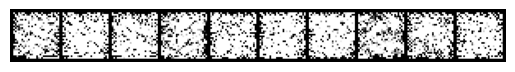

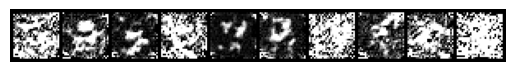

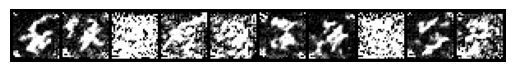

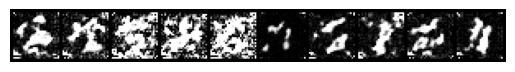

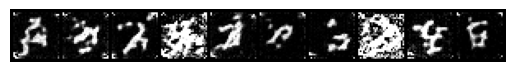

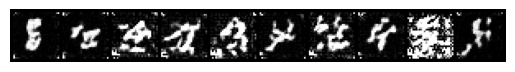

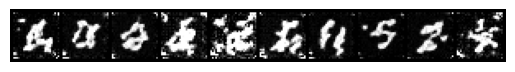

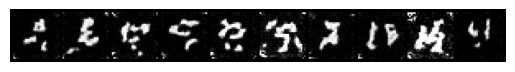

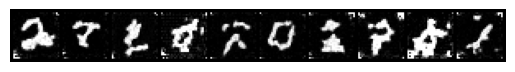

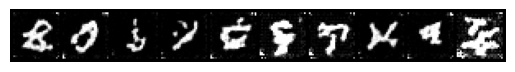

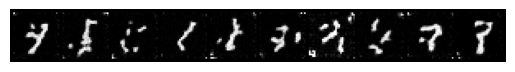

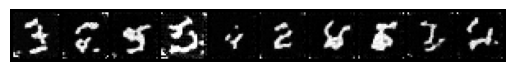

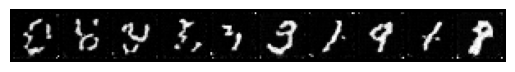

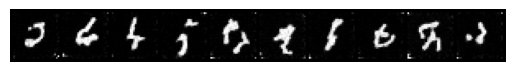

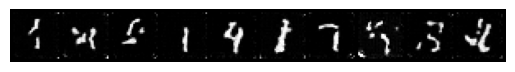

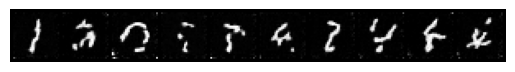

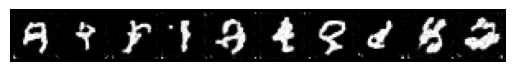

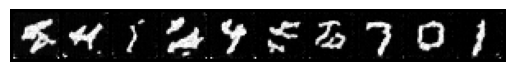

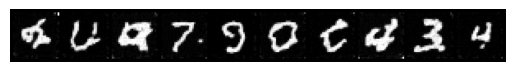

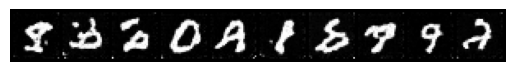

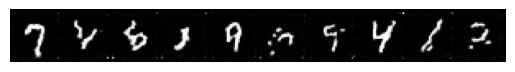

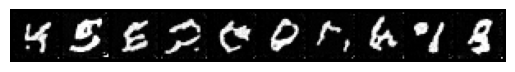

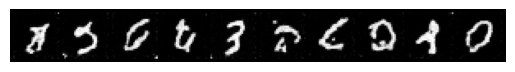

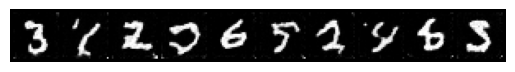

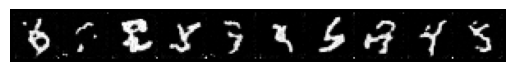

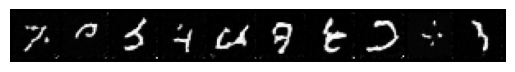

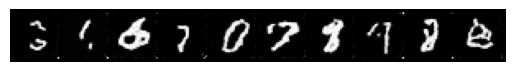

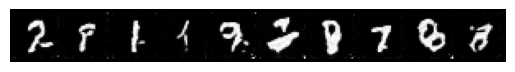

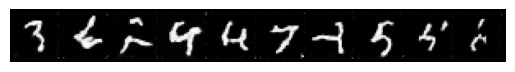

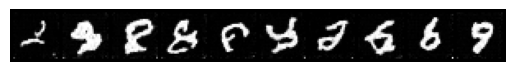

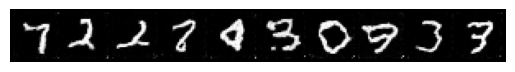

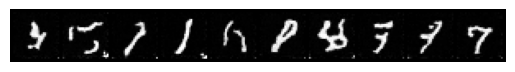

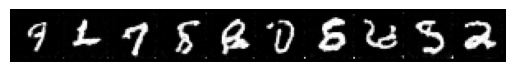

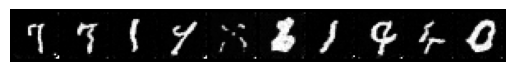

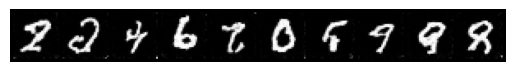

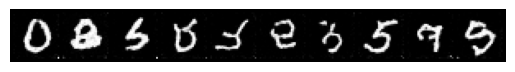

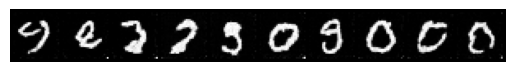

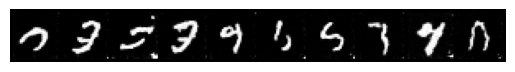

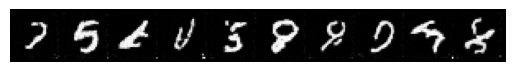

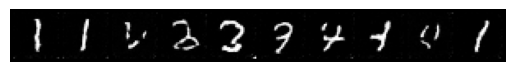

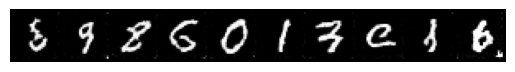

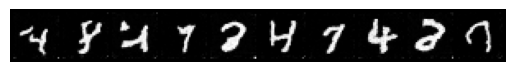

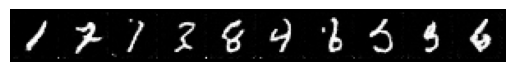

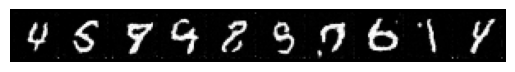

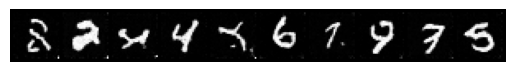

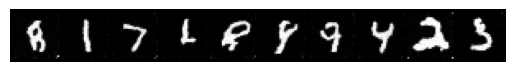

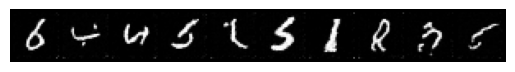

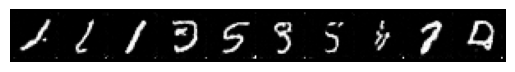

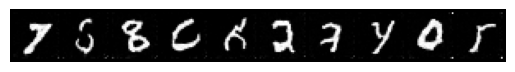

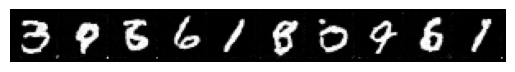

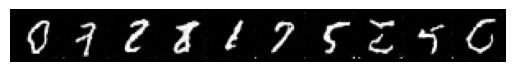

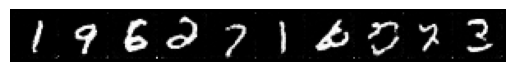

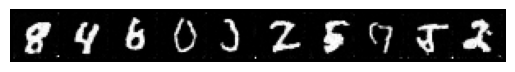

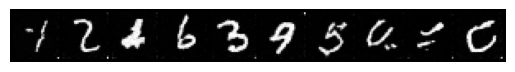

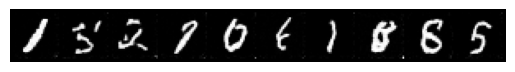

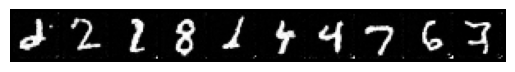

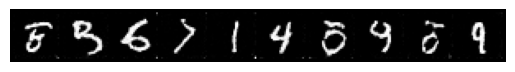

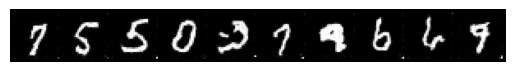

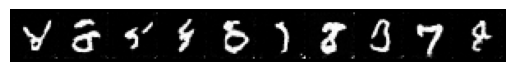

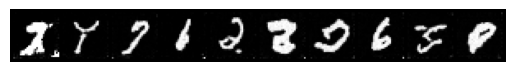

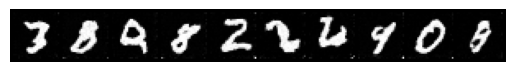

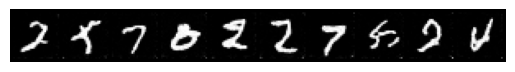

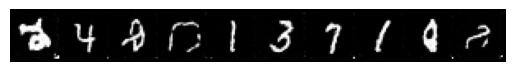

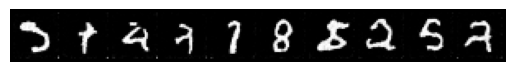

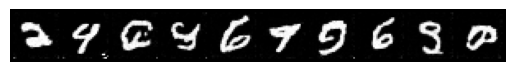

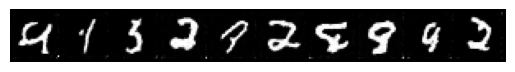

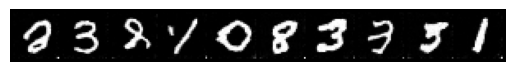

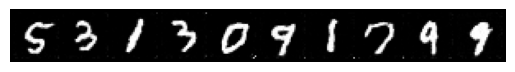

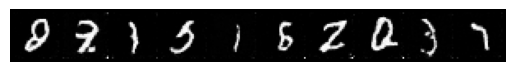

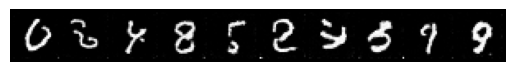

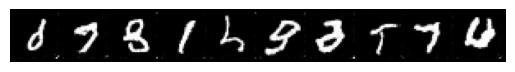

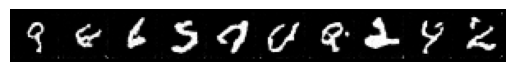

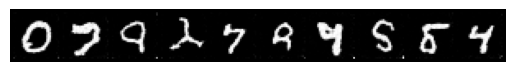

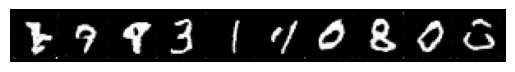

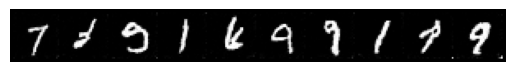

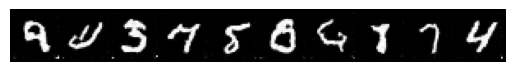

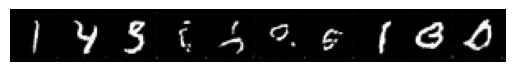

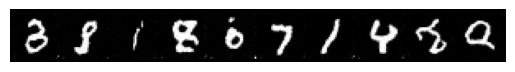

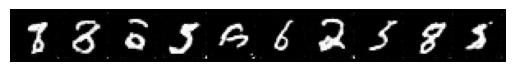

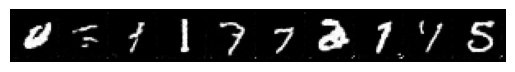

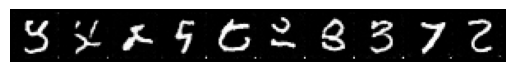

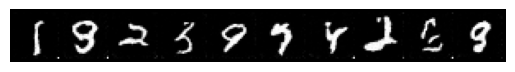

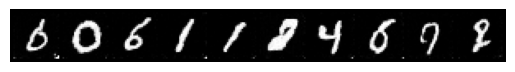

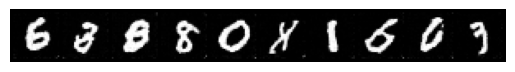

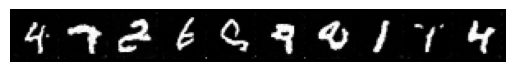

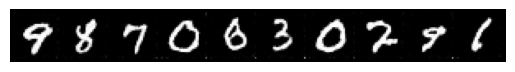

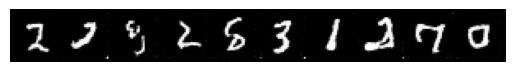

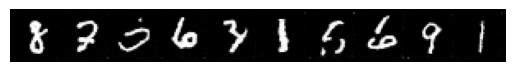

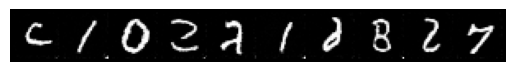

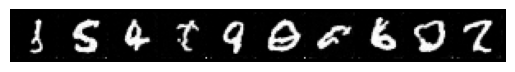

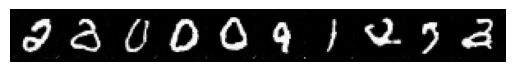

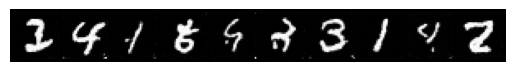

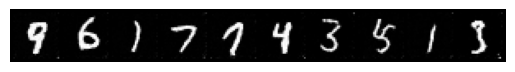

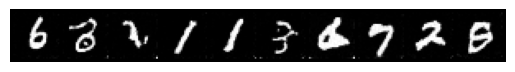

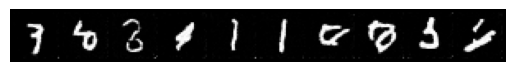

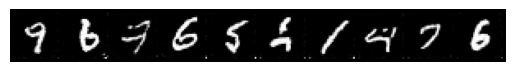

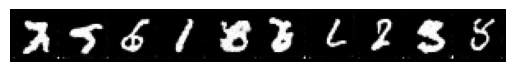

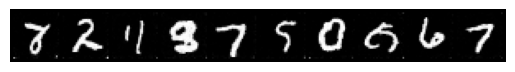

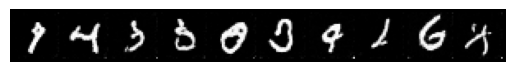

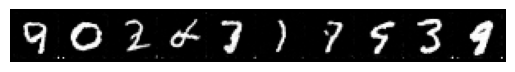

In [32]:
# Call training loop
base_model = train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

In [7]:
# Train and sample from all SDEs
results = train_and_sample_all_sdes(device=device)




Training VP SDE
Skipping batch due to high loss: 126148.453125
Skipping batch due to high loss: 129375.53125
Skipping batch due to high loss: 137083.5
Skipping batch due to high loss: 136250.171875
Skipping batch due to high loss: 125934.703125
Skipping batch due to high loss: 131171.46875
Skipping batch due to high loss: 100140.265625
Skipping batch due to high loss: 128677.546875
Skipping batch due to high loss: 149198.25
Skipping batch due to high loss: 131483.703125
Skipping batch due to high loss: 101700.8125
Skipping batch due to high loss: 140424.625
Skipping batch due to high loss: 115851.3046875


/tmp/ipykernel_15082/1115263328.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Skipping batch due to high loss: 126152.84375
Epoch 1, Average Loss: 2988.01151, LR: 1.00e-04
Epoch 2, Average Loss: 104.58935, LR: 1.00e-04
Epoch 3, Average Loss: 61.21445, LR: 1.00e-04
Epoch 4, Average Loss: 49.22258, LR: 1.00e-04
Epoch 5, Average Loss: 43.48532, LR: 1.00e-04
Epoch 6, Average Loss: 39.42736, LR: 1.00e-04
Epoch 7, Average Loss: 37.77429, LR: 1.00e-04
Epoch 8, Average Loss: 35.49314, LR: 1.00e-04
Epoch 9, Average Loss: 33.86756, LR: 1.00e-04
Epoch 10, Average Loss: 32.37440, LR: 9.00e-05
Epoch 11, Average Loss: 31.45799, LR: 9.00e-05
Epoch 12, Average Loss: 30.73744, LR: 9.00e-05
Epoch 13, Average Loss: 29.96282, LR: 9.00e-05
Epoch 14, Average Loss: 29.41397, LR: 9.00e-05
Epoch 15, Average Loss: 28.95316, LR: 9.00e-05
Epoch 16, Average Loss: 28.42049, LR: 9.00e-05
Epoch 17, Average Loss: 28.03203, LR: 9.00e-05
Epoch 18, Average Loss: 27.87806, LR: 9.00e-05
Epoch 19, Average Loss: 27.26613, LR: 9.00e-05
Epoch 20, Average Loss: 26.83344, LR: 8.10e-05
Epoch 21, Average Lo

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_15082/1115263328.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)



Training VE SDE


/tmp/ipykernel_15082/1115263328.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Skipping batch due to high loss: 196675.828125
Epoch 1, Average Loss: 1120.70326, LR: 5.00e-05
Epoch 2, Average Loss: 956.60855, LR: 5.00e-05
Skipping batch due to high loss: 120346.671875
Skipping batch due to high loss: 612057.6875
Epoch 3, Average Loss: 570.14456, LR: 5.00e-05
Skipping batch due to high loss: 299958.90625
Skipping batch due to high loss: 105319.6015625
Epoch 4, Average Loss: 690.40458, LR: 5.00e-05
Skipping batch due to high loss: 170397.578125
Skipping batch due to high loss: 334082.53125
Epoch 5, Average Loss: 757.89684, LR: 5.00e-05
Skipping batch due to high loss: 118279.3046875
Epoch 6, Average Loss: 677.28100, LR: 5.00e-05
Skipping batch due to high loss: 117744.390625
Epoch 7, Average Loss: 653.32644, LR: 5.00e-05
Skipping batch due to high loss: 299218.59375
Skipping batch due to high loss: 135030.515625
Epoch 8, Average Loss: 665.42916, LR: 5.00e-05
Epoch 9, Average Loss: 593.28753, LR: 5.00e-05
Skipping batch due to high loss: 240635.796875
Skipping batch 

  0%|          | 0/1000 [00:00<?, ?it/s]


Training SUBVP SDE


/tmp/ipykernel_15082/1115263328.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch 1, Average Loss: 685.83439, LR: 8.00e-05
Epoch 2, Average Loss: 73.50657, LR: 8.00e-05
Epoch 3, Average Loss: 60.01661, LR: 8.00e-05
Epoch 4, Average Loss: 53.74014, LR: 8.00e-05
Epoch 5, Average Loss: 50.22062, LR: 8.00e-05
Epoch 6, Average Loss: 47.38645, LR: 8.00e-05
Epoch 7, Average Loss: 45.69632, LR: 8.00e-05
Epoch 8, Average Loss: 44.23799, LR: 8.00e-05
Epoch 9, Average Loss: 43.15896, LR: 8.00e-05
Epoch 10, Average Loss: 41.73363, LR: 7.20e-05
Epoch 11, Average Loss: 41.12288, LR: 7.20e-05
Epoch 12, Average Loss: 40.24220, LR: 7.20e-05
Epoch 13, Average Loss: 39.86314, LR: 7.20e-05
Epoch 14, Average Loss: 39.19824, LR: 7.20e-05
Epoch 15, Average Loss: 38.83952, LR: 7.20e-05
Epoch 16, Average Loss: 38.38449, LR: 7.20e-05
Epoch 17, Average Loss: 38.20818, LR: 7.20e-05
Epoch 18, Average Loss: 37.63843, LR: 7.20e-05
Epoch 19, Average Loss: 37.23768, LR: 7.20e-05
Epoch 20, Average Loss: 37.00073, LR: 6.48e-05
Epoch 21, Average Loss: 36.44413, LR: 6.48e-05
Epoch 22, Average Los

  0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipykernel_15082/1115263328.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


NameError: name 'plt' is not defined

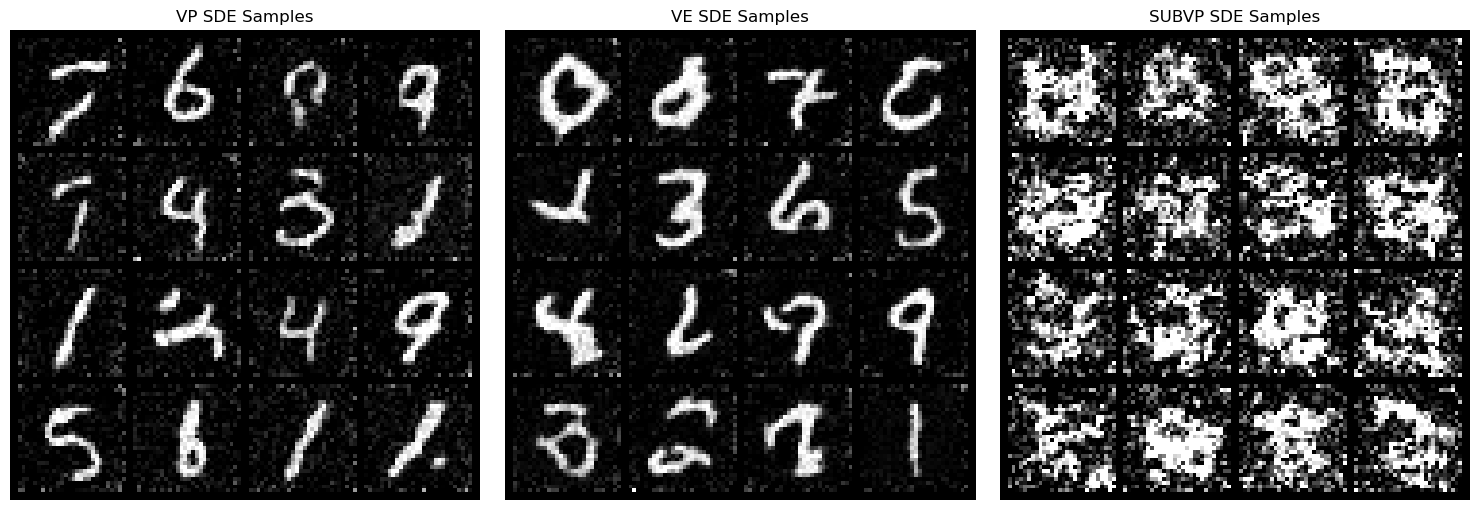

In [11]:

# Visualize the results
plt.figure(figsize=(15, 5))
for idx, (sde_type, samples) in enumerate(results.items(), 1):
    plt.subplot(1, 3, idx)
    samples = samples.clamp(0.0, 1.0)
    sample_grid = make_grid(samples[:16], nrow=4)
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
    plt.title(f'{sde_type.upper()} SDE Samples')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
def train_single_sde_type(sde_type, device='cuda'):
    """
    Train a single SDE model using the original training logic.
    
    Args:
        sde_type (str): One of 'vp', 've', or 'subvp'
        device (str): Device to run on
        
    Returns:
        tuple: (trained_model, samples)
    """
    if sde_type not in ['vp', 've', 'subvp']:
        raise ValueError(f"Invalid SDE type: {sde_type}. Must be one of: 'vp', 've', 'subvp'")
        
    print(f"\nTraining {sde_type.upper()} SDE")
    score_model = ScoreNet((lambda t: torch.ones(1).to(device))).to(device)
    model = train_sde(score_model, sde_type=sde_type, device=device)
    
    # Set up sampling functions based on SDE type
    if sde_type == 'vp':
        marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, sigma=25.0)
        diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, sigma=25.0)
    elif sde_type == 've':
        marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma=2.0)
        diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma=2.0)
    else:  # subvp
        marginal_prob_std_fn = subvp_marginal_prob_std
        diffusion_coeff_fn = subvp_diffusion_coeff
    
    # Sample using original configuration
    config = sde_configs[sde_type]
    samples = pc_sampler(model, 
                        marginal_prob_std_fn, 
                        diffusion_coeff_fn,
                        batch_size=16,
                        device=device,
                        num_steps=config['num_steps'],
                        snr=config['snr'])
    
    return model, samples



In [50]:
# Train VP-SDE
import time

start_time = time.time()

vp_model, vp_samples = train_single_sde_type('vp')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time:.2f} seconds")


Training VP SDE


/tmp/ipykernel_66437/1896588862.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch 1, Average Loss: 4560.60701, LR: 1.00e-04
Epoch 2, Average Loss: 215.41659, LR: 1.00e-04
Epoch 3, Average Loss: 98.79994, LR: 1.00e-04
Epoch 4, Average Loss: 71.27654, LR: 1.00e-04
Epoch 5, Average Loss: 58.60361, LR: 1.00e-04
Epoch 6, Average Loss: 51.05230, LR: 1.00e-04
Epoch 7, Average Loss: 46.23688, LR: 1.00e-04
Epoch 8, Average Loss: 42.71687, LR: 1.00e-04
Epoch 9, Average Loss: 40.12179, LR: 1.00e-04
Epoch 10, Average Loss: 38.29762, LR: 9.00e-05
Epoch 11, Average Loss: 36.05094, LR: 9.00e-05
Epoch 12, Average Loss: 35.21565, LR: 9.00e-05
Epoch 13, Average Loss: 33.72191, LR: 9.00e-05
Epoch 14, Average Loss: 33.40298, LR: 9.00e-05
Epoch 15, Average Loss: 32.71617, LR: 9.00e-05
Epoch 16, Average Loss: 31.79068, LR: 9.00e-05
Epoch 17, Average Loss: 31.19153, LR: 9.00e-05
Epoch 18, Average Loss: 30.93955, LR: 9.00e-05
Epoch 19, Average Loss: 30.40510, LR: 9.00e-05
Epoch 20, Average Loss: 30.02191, LR: 8.10e-05
Epoch 21, Average Loss: 29.42519, LR: 8.10e-05
Epoch 22, Average L

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_66437/1896588862.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Training completed in 506.96 seconds


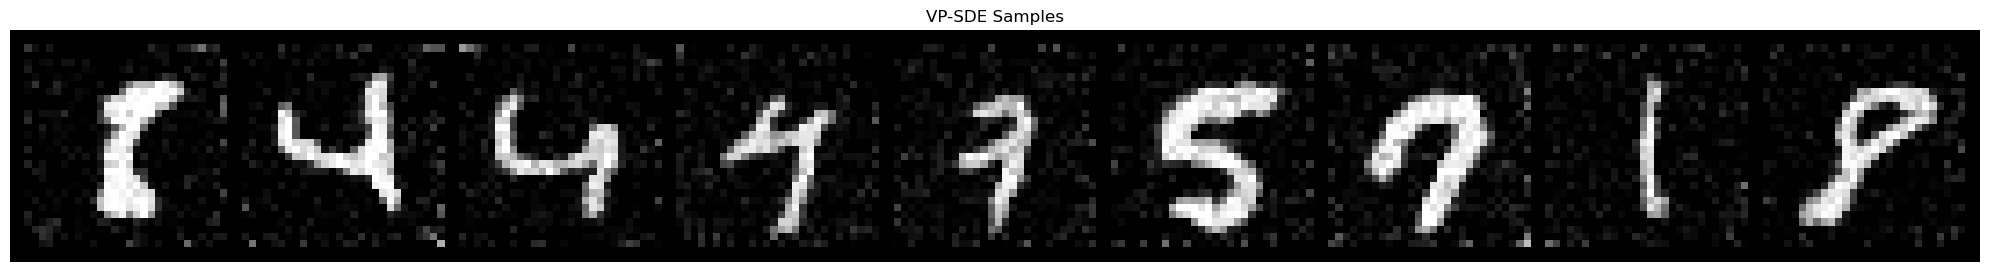

In [51]:
 
plt.figure(figsize=(20, 3))  # Wide but short figure since we're doing a single row

# Clamp the samples to [0, 1] range
samples = vp_samples.clamp(0.0, 1.0)

# Create a single row of samples (using 9 samples)
sample_grid = make_grid(samples[:9], nrow=9)

# Display the grid
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.title('VP-SDE Samples')
plt.axis('off')
plt.tight_layout()
plt.show()

In [52]:
start_time = time.time()

ve_model, ve_samples = train_single_sde_type('ve', device = 'cuda')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time:.2f} seconds")


Training VE SDE


/tmp/ipykernel_66437/1896588862.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch 1, Average Loss: 735.85070, LR: 5.00e-04
Epoch 2, Average Loss: 567.28198, LR: 5.00e-04
Epoch 3, Average Loss: 646.30739, LR: 5.00e-04
Epoch 4, Average Loss: 453.46294, LR: 5.00e-04
Epoch 5, Average Loss: 525.51362, LR: 5.00e-04
Epoch 6, Average Loss: 521.97524, LR: 5.00e-04
Epoch 7, Average Loss: 451.29094, LR: 5.00e-04
Epoch 8, Average Loss: 470.10293, LR: 5.00e-04
Epoch 9, Average Loss: 513.12034, LR: 5.00e-04
Epoch 10, Average Loss: 484.17320, LR: 4.50e-04
Epoch 11, Average Loss: 487.60875, LR: 4.50e-04
Epoch 12, Average Loss: 442.85532, LR: 4.50e-04
Epoch 13, Average Loss: 369.12836, LR: 4.50e-04
Epoch 14, Average Loss: 406.97678, LR: 4.50e-04
Epoch 15, Average Loss: 423.92520, LR: 4.50e-04
Epoch 16, Average Loss: 407.04751, LR: 4.50e-04
Epoch 17, Average Loss: 488.12043, LR: 4.50e-04
Epoch 18, Average Loss: 430.05155, LR: 4.50e-04
Epoch 19, Average Loss: 409.44282, LR: 4.50e-04
Epoch 20, Average Loss: 409.18822, LR: 4.05e-04
Epoch 21, Average Loss: 412.19066, LR: 4.05e-04
E

  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed in 503.12 seconds


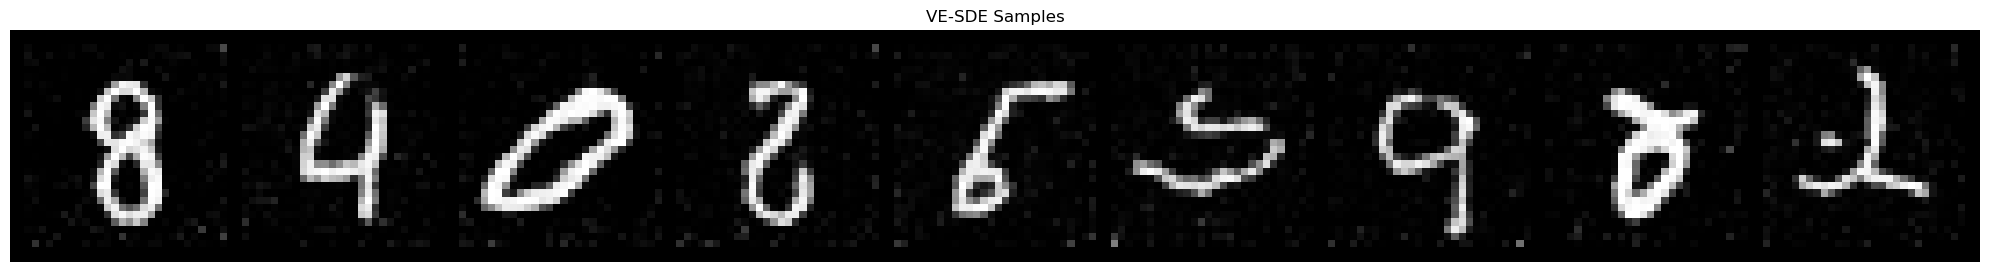

In [53]:
plt.figure(figsize=(20, 3))  # Wide but short figure since we're doing a single row

# Clamp the samples to [0, 1] range
samples = ve_samples.clamp(0.0, 1.0)

# Create a single row of samples (using 9 samples)
sample_grid = make_grid(samples[:9], nrow=9)

# Display the grid
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.title('VE-SDE Samples')
plt.axis('off')
plt.tight_layout()
plt.show()

In [54]:
start_time = time.time()

subvp_model, subvp_samples = train_single_sde_type('subvp')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in {elapsed_time:.2f} seconds")


Training SUBVP SDE


/tmp/ipykernel_66437/1896588862.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Epoch 1, Average Loss: 291.39406, LR: 4.00e-03
Epoch 2, Average Loss: 58.93041, LR: 4.00e-03
Epoch 3, Average Loss: 48.89532, LR: 4.00e-03
Epoch 4, Average Loss: 44.83537, LR: 4.00e-03
Epoch 5, Average Loss: 42.32269, LR: 4.00e-03
Epoch 6, Average Loss: 39.30860, LR: 4.00e-03
Epoch 7, Average Loss: 41.37411, LR: 4.00e-03
Epoch 8, Average Loss: 36.92439, LR: 4.00e-03
Epoch 9, Average Loss: 37.59463, LR: 4.00e-03
Epoch 10, Average Loss: 35.99848, LR: 3.60e-03
Epoch 11, Average Loss: 34.87996, LR: 3.60e-03
Epoch 12, Average Loss: 34.38566, LR: 3.60e-03
Epoch 13, Average Loss: 32.80022, LR: 3.60e-03
Epoch 14, Average Loss: 32.88675, LR: 3.60e-03
Epoch 15, Average Loss: 32.39333, LR: 3.60e-03
Epoch 16, Average Loss: 32.34291, LR: 3.60e-03
Epoch 17, Average Loss: 31.64451, LR: 3.60e-03
Epoch 18, Average Loss: 33.48472, LR: 3.60e-03
Epoch 19, Average Loss: 31.04692, LR: 3.60e-03
Epoch 20, Average Loss: 30.75516, LR: 3.24e-03
Epoch 21, Average Loss: 30.35195, LR: 3.24e-03
Epoch 22, Average Los

  0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipykernel_66437/1896588862.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Training completed in 510.48 seconds


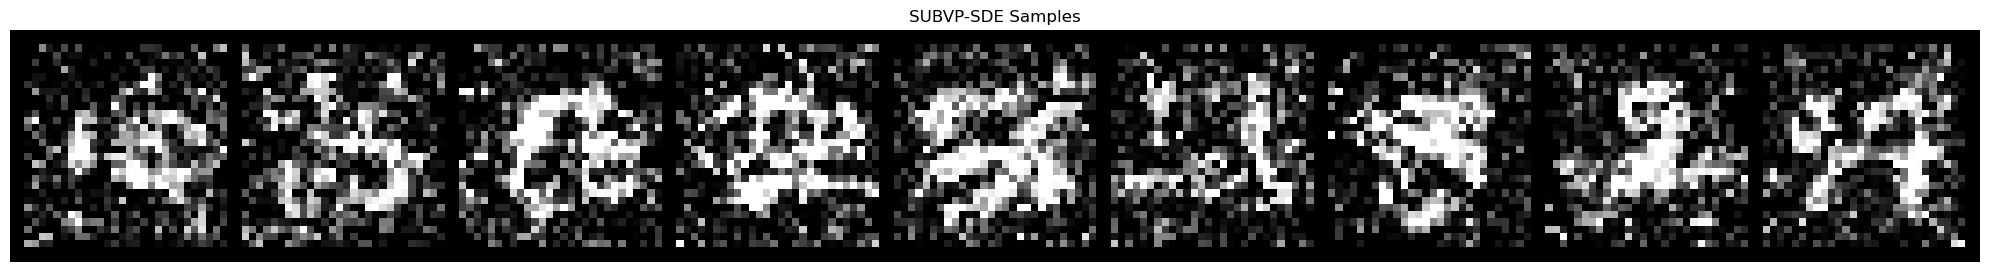

In [55]:
plt.figure(figsize=(20, 3))  # Wide but short figure since we're doing a single row

# Clamp the samples to [0, 1] range
samples = subvp_samples.clamp(0.0, 1.0)

# Create a single row of samples (using 9 samples)
sample_grid = make_grid(samples[:9], nrow=9)

# Display the grid
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), cmap='gray')
plt.title('SUBVP-SDE Samples')
plt.axis('off')
plt.tight_layout()
plt.show()

In [56]:
ode_vp_samples = sample_single_sde_ODE('vp', model=vp_model, error_tol=1e-7)

/tmp/ipykernel_66437/1896588862.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/1896588862.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 9134


In [57]:
ode_ve_samples = sample_single_sde_ODE('ve', model=ve_model, error_tol=1e-7)

/tmp/ipykernel_66437/1896588862.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 3032


In [58]:
ode_subvp_samples = sample_single_sde_ODE('subvp', model=subvp_model, error_tol=1e-7)

/tmp/ipykernel_66437/1896588862.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/1896588862.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 914


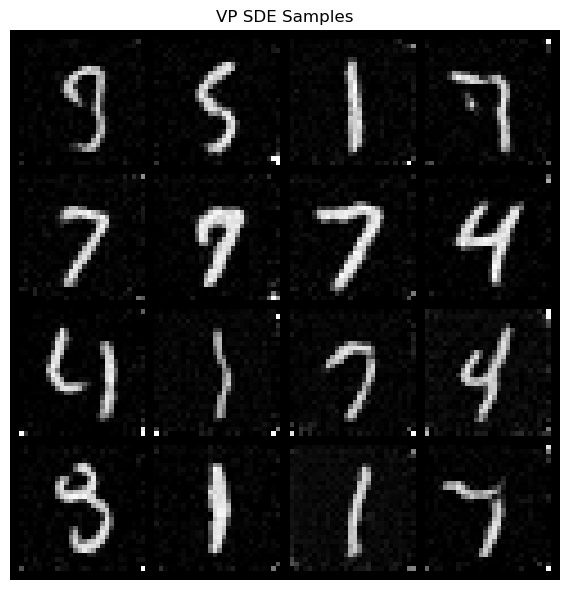

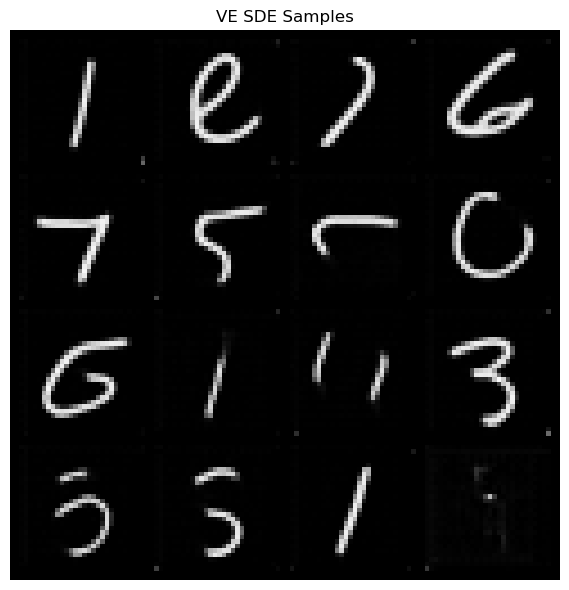

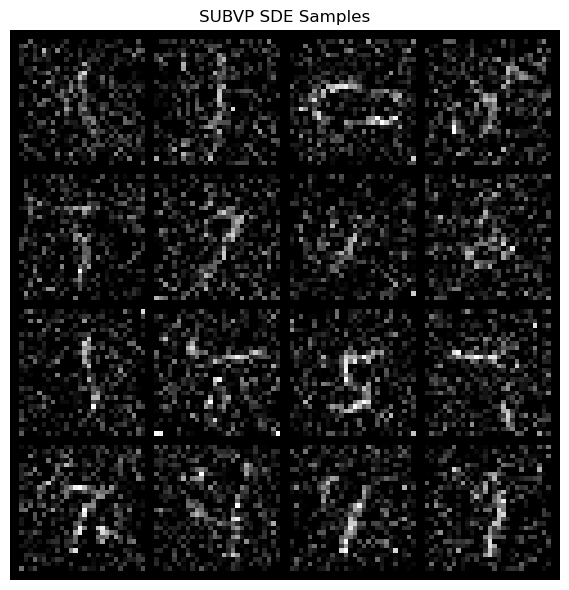

In [59]:
visualize_single_sde(ode_vp_samples, 'vp', save_path='ode_vp_samples.png')
visualize_single_sde(ode_ve_samples, 've', save_path='ode_ve_samples.png')
visualize_single_sde(ode_subvp_samples, 'subvp', save_path='ode_subvp_samples.png')

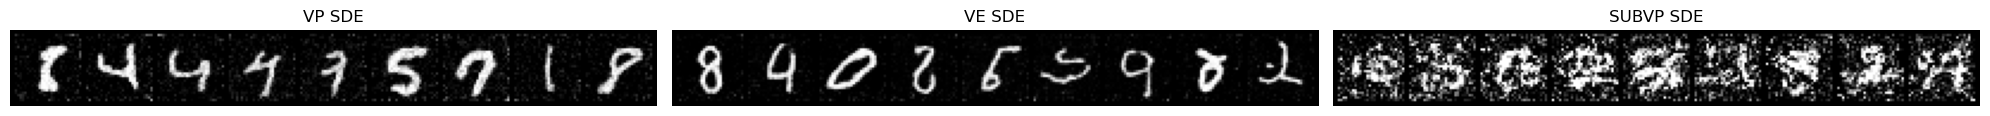

In [60]:
samples_dict = {
    'vp': vp_samples,
    've': ve_samples,
    'subvp': subvp_samples
}
visualize_all_sdes(samples_dict, nrow=9, figsize=(20, 4))


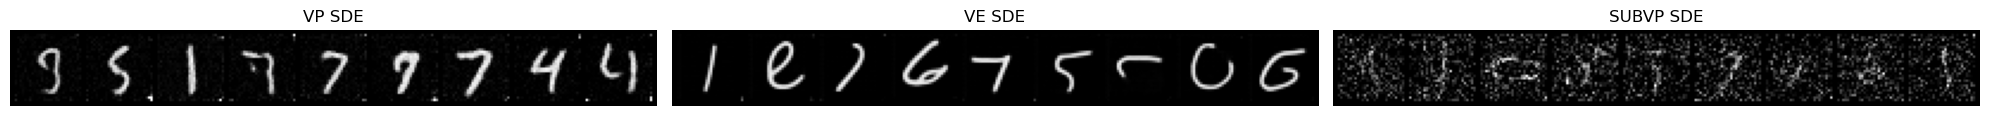

In [61]:
# Example usage:
samples_dict_ode = {
    'vp': ode_vp_samples,
    've': ode_ve_samples,
    'subvp': ode_subvp_samples
}
visualize_all_sdes(samples_dict_ode, nrow=9, figsize=(20, 4))


**MODEL EVALUATION**

In [64]:
import torch
import torch.nn.functional as F
from torchvision.models import inception_v3
from torchvision import datasets, transforms
import scipy
from scipy.linalg import sqrtm
import numpy as np

# Load pre-trained InceptionV3
inception = inception_v3(pretrained=True, transform_input=False).eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception = inception.to(device)

# FID Calculation
def calculate_fid(real_features, generated_features):
    """
    Compute Frechet Inception Distance (FID) between real and generated features.

    Parameters
    ----------
    real_features : np.ndarray
        Features from the real images, shape (N, D).
    generated_features : np.ndarray
        Features from the generated images, shape (N, D).

    Returns
    -------
    float
        FID score.
    """
    # Mean and covariance of real (r) and generated features (g)
    mu_r, sigma_r = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_g, sigma_g = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Compute squared difference of means
    diff = mu_r - mu_g
    mean_norm = np.sum(diff**2)

    # Compute sqrt of product of covariance matrices
    cov_mean = sqrtm(sigma_r @ sigma_g)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real  # Handle numerical instability

    # Compute FID
    fid = mean_norm + np.trace(sigma_r + sigma_g - 2 * cov_mean)
    return fid

# IS Calculation
def calculate_inception_score(generated_images, inception, splits=10):
    """
    Compute Inception Score (IS) for a set of generated images.

    Parameters
    ----------
    generated_images : torch.Tensor
        Generated images, shape (N, C, H, W).
    inception : nn.Module
        Pre-trained Inception model.
    splits : int, optional
        Number of splits for IS computation.

    Returns
    -------
    float
        Inception Score.
    """
    with torch.no_grad():
        # Resize images to 299x299 for pre-trained InceptionV3
        generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear')
        logits = inception(generated_images)  # Pass through InceptionV3
        probabilities = F.softmax(logits, dim=1).cpu().numpy()

    # Split the probabilities into groups for KL divergence calculation
    scores = []
    for i in range(splits):
        part = probabilities[i * (len(probabilities) // splits):(i + 1) * (len(probabilities) // splits), :]
        p_y = np.mean(part, axis=0)  # Marginal distribution
        kl_div = part * (np.log(part) - np.log(p_y))  # KL divergence
        scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))

    return np.mean(scores)  # Mean score over splits

# Feature Extraction
def extract_features(images, inception, batch_size=64):
    """
    Extract features from Inception's pool3 layer for a batch of images.

    Parameters
    ----------
    images : torch.Tensor
        Images to extract features from, shape (N, C, H, W).
    inception : nn.Module
        Pre-trained Inception model.
    batch_size : int
        Batch size for feature extraction.

    Returns
    -------
    np.ndarray
        Extracted features, shape (N, D).
    """
    features = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size].to(device)
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear')  # Resize for InceptionV3
            batch_features = inception(batch).cpu().numpy()
            features.append(batch_features)
    return np.concatenate(features, axis=0)

/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/ucloud/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 326MB/s] 


In [ ]:
# Collect real images from the dataloader
real_images = []
num_samples = 1000  # Number of real images to match generated samples
for x, _ in dataloader_train:
    real_images.append(x)
    if len(torch.cat(real_images)) >= num_samples:
        break

real_images = torch.cat(real_images)[:num_samples]
real_images = real_images.view(-1, 1, 28, 28)
real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels for InceptionV3

def sample_generated_images_ode(model, sde_type, num_samples=1000, device='cuda', error_tol=1e-7):
    """Sample images using the ODE sampler with explicit float32 type"""
    samples = sample_single_sde_ODE(sde_type, model, device, error_tol=error_tol)
    # Convert to float32 and 3 channels
    samples = samples.float()  # Ensure float32
    samples = samples.repeat(1, 3, 1, 1)
    return samples
    
def sample_generated_images_pc(model, sde_type, num_samples=1000, device='cuda'):
    """
    Sample images using the PC sampler
    
    Args:
        model: The trained score model
        sde_type: Type of SDE ('vp', 've', or 'subvp')
        device: Device to run on
    """
    # Set up the appropriate functions based on SDE type
    if sde_type == 'vp':
        marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, sigma=25.0)
        diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, sigma=25.0)
    elif sde_type == 've':
        marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma=2.0)
        diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma=2.0)
    else:  # subvp
        marginal_prob_std_fn = subvp_marginal_prob_std
        diffusion_coeff_fn = subvp_diffusion_coeff
    
    config = sde_configs[sde_type]
    samples = pc_sampler(
        model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        batch_size=num_samples,
        device=device,
        num_steps=config['num_steps'],
        snr=config['snr']
    )
    # Convert to 3 channels for InceptionV3
    samples = samples.repeat(1, 3, 1, 1)
    return samples

def agg_metrics(model, real_images, sde_type, sampler_type='pc', metric='FID', num_runs=5, batch_size=64, splits=10, error_tol=1e-5):
    """
    Evaluate FID or IS multiple times and return the average and standard deviation.
    
    Parameters:
        model: The trained score model
        real_images: Real images to calculate FID
        sde_type: Type of SDE ('vp', 've', or 'subvp')
        sampler_type: Type of sampler to use ('pc' or 'ode')
        metric: Metric to calculate ("FID" or "IS")
        num_runs: Number of runs for averaging metrics
        batch_size: Batch size for feature extraction
        splits: Number of splits for IS computation
        error_tol: Error tolerance for ODE solver (only used if sampler_type='ode')
    """
    scores = []
    real_features = extract_features(real_images, inception)
    
    for run in range(num_runs):
        # Generate images using specified sampler
        if sampler_type == 'ode':
            generated_images = sample_generated_images_ode(model, sde_type, 
                                                        num_samples=len(real_images), 
                                                        device=device,
                                                        error_tol=error_tol)
        else:  # pc sampler
            generated_images = sample_generated_images_pc(model, sde_type,
                                                        num_samples=len(real_images),
                                                        device=device)
        
        if metric == "FID":
            generated_features = extract_features(generated_images, inception)
            score = calculate_fid(real_features, generated_features)
        elif metric == "IS":
            score = calculate_inception_score(generated_images, inception, splits)
        else:
            raise ValueError("Invalid metric. Choose either 'FID' or 'IS'.")
        
        scores.append(score)
    
    return {"mean": np.mean(scores), "std": np.std(scores)}



In [68]:
print("Results with PC Sampler:")

# VP-SDE
fid_results_vp_pc = agg_metrics(vp_model, real_images, 'vp', sampler_type='pc', metric="FID")
is_results_vp_pc = agg_metrics(vp_model, real_images, 'vp', sampler_type='pc', metric="IS")
print("VP-SDE Results:")
print(f"FID Score: {fid_results_vp_pc['mean']:.2f} ± {fid_results_vp_pc['std']:.2f}")
print(f"Inception Score: {is_results_vp_pc['mean']:.2f} ± {is_results_vp_pc['std']:.2f}")
print()

# VE-SDE
fid_results_ve_pc = agg_metrics(ve_model, real_images, 've', sampler_type='pc', metric="FID")
is_results_ve_pc = agg_metrics(ve_model, real_images, 've', sampler_type='pc', metric="IS")
print("VE-SDE Results:")
print(f"FID Score: {fid_results_ve_pc['mean']:.2f} ± {fid_results_ve_pc['std']:.2f}")
print(f"Inception Score: {is_results_ve_pc['mean']:.2f} ± {is_results_ve_pc['std']:.2f}")
print()

# subVP-SDE
fid_results_subvp_pc = agg_metrics(subvp_model, real_images, 'subvp', sampler_type='pc', metric="FID")
is_results_subvp_pc = agg_metrics(subvp_model, real_images, 'subvp', sampler_type='pc', metric="IS")
print("subVP-SDE Results:")
print(f"FID Score: {fid_results_subvp_pc['mean']:.2f} ± {fid_results_subvp_pc['std']:.2f}")
print(f"Inception Score: {is_results_subvp_pc['mean']:.2f} ± {is_results_subvp_pc['std']:.2f}")


Results with PC Sampler:


/tmp/ipykernel_66437/3723849436.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

VP-SDE Results:
FID Score: 668.34 ± 5.65
Inception Score: 2.09 ± 0.02



/tmp/ipykernel_66437/3723849436.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

VE-SDE Results:
FID Score: 516.66 ± 2.31
Inception Score: 1.95 ± 0.03



/tmp/ipykernel_66437/3723849436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

subVP-SDE Results:
FID Score: 1537.40 ± 6.41
Inception Score: 1.50 ± 0.01


In [ ]:
# Collect real images from the dataloader
real_images = []
num_samples = 1000  # Number of real images to match generated samples
for x, _ in dataloader_train:
    real_images.append(x)
    if len(torch.cat(real_images)) >= num_samples:
        break

real_images = torch.cat(real_images)[:num_samples]
real_images = real_images.view(-1, 1, 28, 28)
real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels for InceptionV3



In [91]:
# Example usage for ODE sampler:
print("\nResults with ODE Sampler:")
# VP-SDE
fid_results_vp_ode = agg_metrics(vp_model, real_images, 'vp', sampler_type='ode', metric="FID")
is_results_vp_ode = agg_metrics(vp_model, real_images, 'vp', sampler_type='ode', metric="IS")
print(f"VP-SDE FID Score: {fid_results_vp_ode['mean']:.2f} ± {fid_results_vp_ode['std']:.2f}")
print(f"VP-SDE Inception Score: {is_results_vp_ode['mean']:.2f} ± {is_results_vp_ode['std']:.2f}")

# VE-SDE
fid_results_ve_ode = agg_metrics(ve_model, real_images, 've', sampler_type='ode', metric="FID")
is_results_ve_ode = agg_metrics(ve_model, real_images, 've', sampler_type='ode', metric="IS")
print("VE-SDE Results:")
print(f"FID Score: {fid_results_ve_ode['mean']:.2f} ± {fid_results_ve_ode['std']:.2f}")
print(f"Inception Score: {is_results_ve_ode['mean']:.2f} ± {is_results_ve_ode['std']:.2f}")
print()

# subVP-SDE
fid_results_subvp_ode = agg_metrics(subvp_model, real_images, 'subvp', sampler_type='ode', metric="FID")
is_results_subvp_ode = agg_metrics(subvp_model, real_images, 'subvp', sampler_type='ode', metric="IS")
print("subVP-SDE Results:")
print(f"FID Score: {fid_results_subvp_ode['mean']:.2f} ± {fid_results_subvp_ode['std']:.2f}")
print(f"Inception Score: {is_results_subvp_ode['mean']:.2f} ± {is_results_subvp_ode['std']:.2f}")


Results with ODE Sampler:


/tmp/ipykernel_66437/3723849436.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/3723849436.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 500
Number of function evaluations: 512
Number of function evaluations: 500
Number of function evaluations: 506
Number of function evaluations: 500
Number of function evaluations: 512
Number of function evaluations: 512
Number of function evaluations: 512
Number of function evaluations: 500
Number of function evaluations: 512
VP-SDE FID Score: 856.06 ± 27.98
VP-SDE Inception Score: 1.00 ± 0.00


/tmp/ipykernel_66437/3723849436.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 308
Number of function evaluations: 302
Number of function evaluations: 326
Number of function evaluations: 344
Number of function evaluations: 308
Number of function evaluations: 302
Number of function evaluations: 302
Number of function evaluations: 302
Number of function evaluations: 296
Number of function evaluations: 302
VE-SDE Results:
FID Score: 658.88 ± 11.35
Inception Score: 1.00 ± 0.00



/tmp/ipykernel_66437/3723849436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/3723849436.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 152
Number of function evaluations: 134
Number of function evaluations: 146
Number of function evaluations: 146
Number of function evaluations: 164
Number of function evaluations: 140
Number of function evaluations: 146
Number of function evaluations: 128
Number of function evaluations: 134
Number of function evaluations: 140
subVP-SDE Results:
FID Score: 1461.47 ± 41.24
Inception Score: 1.00 ± 0.00


In [75]:
fid_results_base = agg_metrics(model, real_images, metric = "FID")
is_results_base = agg_metrics(model, real_images, metric = "IS")

print("Noise Level (epsilon) Parameterization:")
print("")
print(f"FID Score: {fid_results_base['mean']:.2f} ± {fid_results_base['std']:.2f}")
print(f"Inception Score: {is_results_base['mean']:.2f} ± {is_results_base['std']:.2f}")


Noise Level (epsilon) Parameterization:

FID Score: 336.15 ± 3.30
Inception Score: 2.18 ± 0.03


In [80]:
# Collect real images from the dataloader
real_images = []
num_samples = 1000  # Number of real images to match generated samples
for x, _ in dataloader_train:
    real_images.append(x)
    if len(torch.cat(real_images)) >= num_samples:
        break

real_images = torch.cat(real_images)[:num_samples]
real_images = real_images.view(-1, 1, 28, 28)
real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels for InceptionV3

def sample_generated_images(model, num_samples=1000):
    generated_images = (model.sample((num_samples, 28 * 28)).reshape(-1, 1, 28, 28)).repeat(1, 3, 1, 1) # Convert to 3 channels for InceptionV3
    return generated_images

def agg_metrics(model, real_images, metric, num_runs=5, batch_size=64, splits=10):
    """
    Evaluate FID or IS multiple times and return the average and standard deviation.

    Parameters
    ----------
    real_images : torch.Tensor
        Real images to calculate FID, shape (N, C, H, W).
    generated_images: callable
        A function that generates a batch of images, shape (N, C, H, W).
    metric : str
        Metric to calculate ("FID" or "IS").
    num_runs : int, optional
        Number of runs for averaging metrics, default is 5.
    batch_size : int, optional
        Batch size for feature extraction and generation.
    splits : int, optional
        Number of splits for IS computation (used only for IS).

    Returns
    -------
    dict
        Dictionary containing the average and standard deviation of the chosen metric.
    """
    scores = []
    real_features = extract_features(real_images, inception)

    for run in range(num_runs):
        # Generate images for the current run
        generated_images = sample_generated_images(model)

        # Ensure generated images are on the correct device
        generated_images = generated_images.to(device)

        if metric == "FID":
            # Extract features for generated images
            generated_features = extract_features(generated_images, inception)
            # Calculate FID
            score = calculate_fid(real_features, generated_features)

        elif metric == "IS":
            # Calculate IS directly from generated images
            score = calculate_inception_score(generated_images, inception)

        else:
            raise ValueError("Invalid metric. Choose either 'FID' or 'IS'.")

        scores.append(score)

    # Calculate average and standard deviation
    avg_score = np.mean(scores)
    std_score = np.std(scores)

    return {"mean": avg_score, "std": std_score}



In [81]:
import inspect
from typing import Dict, List, Optional, Tuple
from torchvision.models import inception_v3
from scipy import linalg

class InceptionStatistics:
    """Compute inception statistics for FID and IS scores"""
    def __init__(self, device):
        self.device = device
        self.inception = inception_v3(pretrained=True, transform_input=False).to(device)
        self.inception.eval()
        
        # Create a hook to capture features
        self.features = None
        def hook(module, input, output):
            self.features = output.detach()
        
        # Register the hook on the avgpool layer
        self.inception.avgpool.register_forward_hook(hook)
    
    def get_inception_features(self, images: torch.Tensor, batch_size: int = 50) -> Tuple[np.ndarray, np.ndarray]:
        """Extract both features and logits in a single pass"""
        n_samples = images.shape[0]
        features_list = []
        logits_list = []
        
        for i in range(0, n_samples, batch_size):
            batch = images[i:i+batch_size]
            if batch.dim() == 2:
                batch = batch.reshape(-1, 1, 28, 28)
            if batch.shape[1] == 1:
                batch = batch.repeat(1, 3, 1, 1)
                
            # Resize to inception input size
            batch = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            with torch.no_grad():
                logits = self.inception(batch)
                features = self.features.squeeze()
                
            features_list.append(features.cpu().numpy())
            logits_list.append(logits.cpu().numpy())
            
        return np.concatenate(features_list), np.concatenate(logits_list)

    def compute_statistics(self, features: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Compute mean and covariance for FID"""
        mu = np.mean(features, axis=0)
        sigma = np.cov(features, rowvar=False)
        return mu, sigma
    
    def compute_fid(self, real_features: np.ndarray, fake_features: np.ndarray) -> float:
        """Compute Fréchet Inception Distance"""
        mu1, sigma1 = self.compute_statistics(real_features)
        mu2, sigma2 = self.compute_statistics(fake_features)
        
        diff = mu1 - mu2
        covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
        return float(fid)
    
    def compute_inception_score(self, logits: np.ndarray, splits: int = 10) -> Tuple[float, float]:
        """Compute Inception Score from logits"""
        probs = F.softmax(torch.from_numpy(logits), dim=1).numpy()
        
        scores = []
        split_size = probs.shape[0] // splits
        for i in range(splits):
            part = probs[i * split_size:(i + 1) * split_size]
            kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
            kl = np.mean(np.sum(kl, 1))
            scores.append(np.exp(kl))
            
        return np.mean(scores), np.std(scores)

            break
    real_images = torch.cat(real_images, dim=0)[:n_samples]
    real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels for InceptionV3
    
    # Compute real features once
    print("Computing inception features for real images...")
    real_features, _ = evaluator.get_inception_features(real_images.to(device))
    
    # Multiple evaluation runs
    for run in tqdm(range(n_runs), desc="Evaluation runs"):
        try:
            # Generate fake images using specified sampler
            if sampler_type == 'ode':
                fake_images = sample_generated_images_ode(
                    model, sde_type, 
                    num_samples=n_samples, 
                    device=device,
                    error_tol=error_tol
                )
            else:  # pc sampler
                fake_images = sample_generated_images_pc(
                    model, sde_type,
                    num_samples=n_samples,
                    device=device
                )
            
            # Compute inception features for generated images
            print(f"Computing inception features for generated images (run {run+1}/{n_runs})...")
            fake_features, fake_logits = evaluator.get_inception_features(fake_images.to(device))
            
            # Compute metrics
            fid = evaluator.compute_fid(real_features, fake_features)
            is_mean, is_std = evaluator.compute_inception_score(fake_logits)
            
            # Store results
            fid_scores.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std)
            
        except Exception as e:
            print(f"Error in evaluation run {run+1}: {str(e)}")
            continue
    
    # Compute statistics across runs
    results = {
        'FID': {
            'mean': float(np.mean(fid_scores)),
            'std': float(np.std(fid_scores))
        },
        'IS': {
            'mean': float(np.mean(is_means)),
            'std': float(np.std(is_means))
        }
    }
    
    return results

IndentationError: unexpected indent (2562185579.py, line 78)


Running quantitative comparison...

Evaluating VP SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Computing inception features for generated images (run 1/5)...


  0%|          | 0/500 [00:00<?, ?it/s]

Computing inception features for generated images (run 2/5)...


  0%|          | 0/500 [00:00<?, ?it/s]

Computing inception features for generated images (run 3/5)...


  0%|          | 0/500 [00:00<?, ?it/s]

Computing inception features for generated images (run 4/5)...


  0%|          | 0/500 [00:00<?, ?it/s]

Computing inception features for generated images (run 5/5)...

Evaluating VE SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing inception features for generated images (run 1/5)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing inception features for generated images (run 2/5)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing inception features for generated images (run 3/5)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing inception features for generated images (run 4/5)...


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing inception features for generated images (run 5/5)...

Evaluating sub-VP SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/800 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Computing inception features for generated images (run 1/5)...


  0%|          | 0/800 [00:00<?, ?it/s]

Computing inception features for generated images (run 2/5)...


  0%|          | 0/800 [00:00<?, ?it/s]

Computing inception features for generated images (run 3/5)...


  0%|          | 0/800 [00:00<?, ?it/s]

Computing inception features for generated images (run 4/5)...


  0%|          | 0/800 [00:00<?, ?it/s]

Computing inception features for generated images (run 5/5)...

Generating visualizations...
Generating VP SDE samples...


  0%|          | 0/500 [00:00<?, ?it/s]

Generating VE SDE samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating sub-VP SDE samples...


  0%|          | 0/800 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9769032..1.2483016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61153245..1.0982518].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3664194..2.1192093].


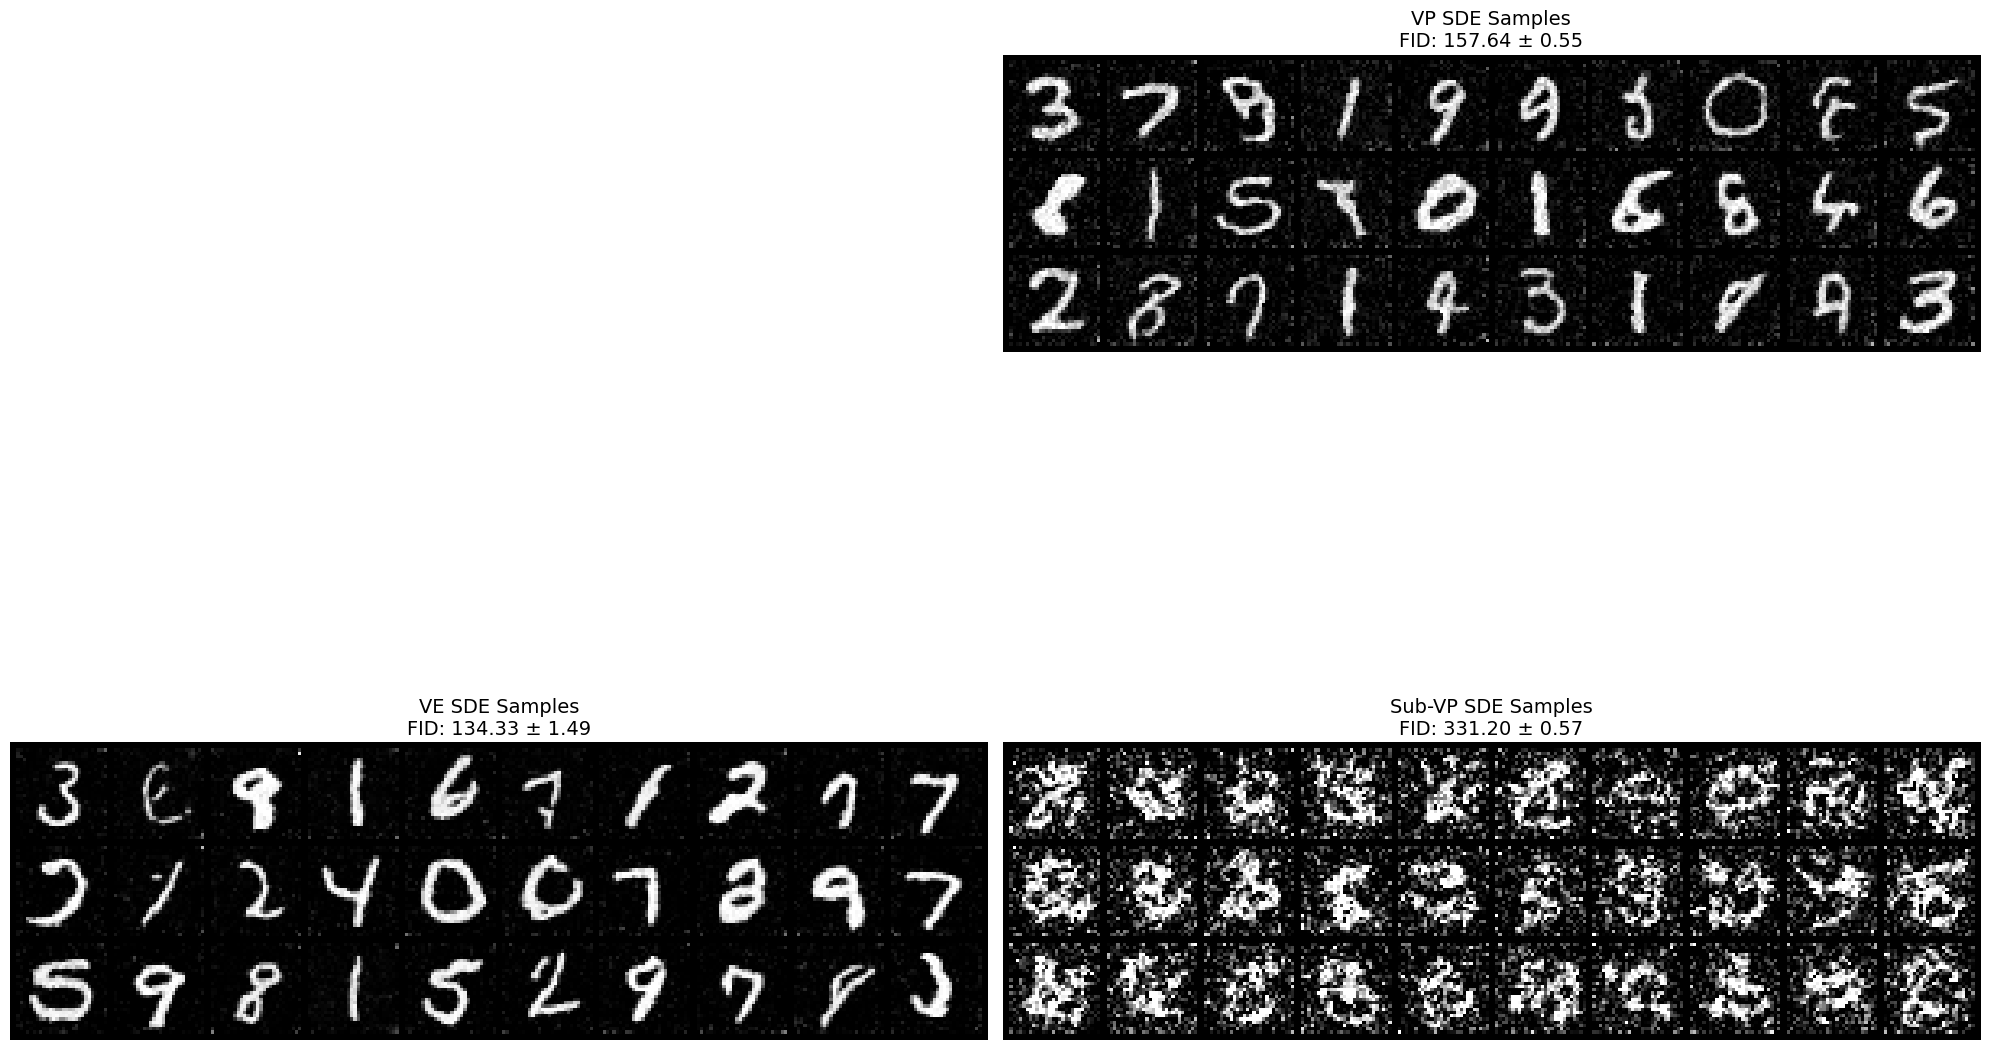

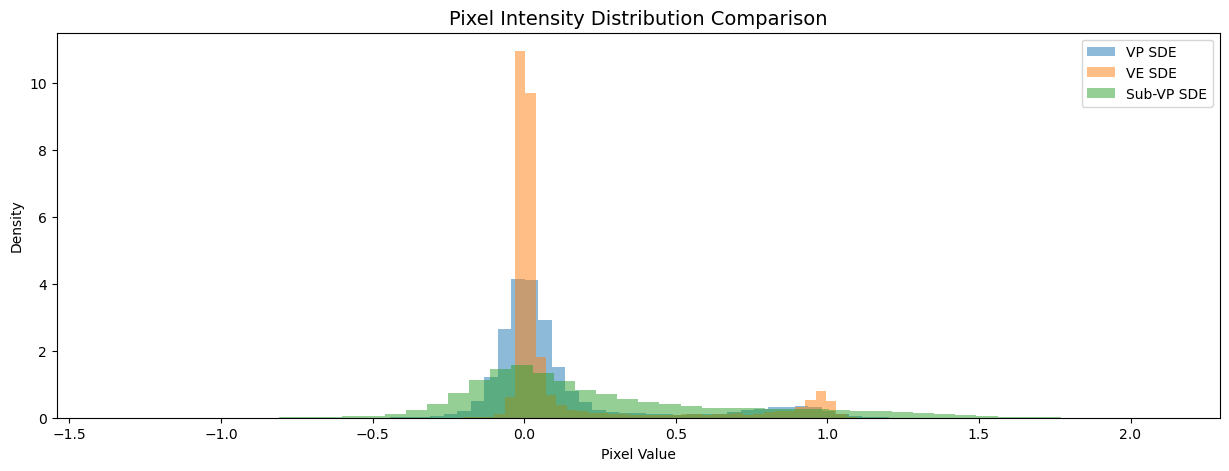

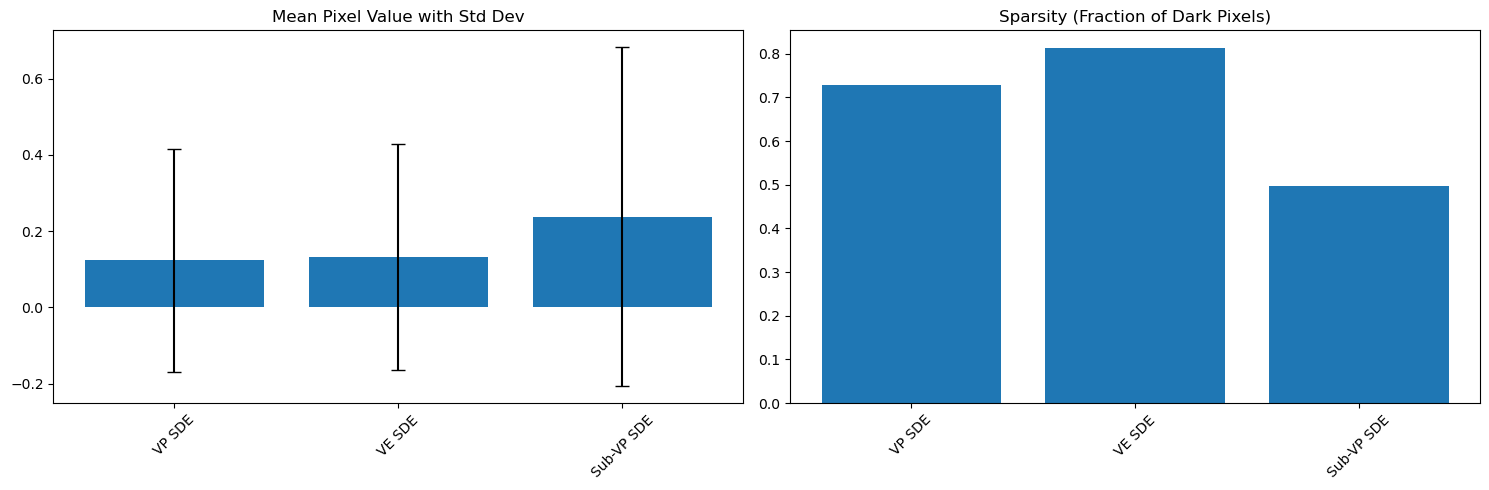

In [85]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run the comparison with multiple runs using PC sampler
results_pc = compare_sde_models_with_viz(
    vp_model=vp_model,
    ve_model=ve_model,
    subvp_model=subvp_model,
    dataloader=dataloader_train,
    device=device,
    sampler_type='pc',
    n_runs=5
)

In [84]:
def evaluate_model_multiple_runs(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    evaluator: InceptionStatistics,
    sde_type: str,
    sampler_type: str = 'pc',
    n_runs: int = 5,
    n_samples: int = 1000,
    batch_size: int = 50,
    device: str = 'cuda',
    error_tol: float = 1e-5
) -> Dict[str, Dict[str, float]]:
    """
    Evaluate diffusion model multiple times using either PC or ODE sampling
    
    Args:
        model: The model to evaluate
        dataloader: DataLoader containing real images
        evaluator: InceptionStatistics instance
        sde_type: Type of SDE ('vp', 've', or 'subvp')
        sampler_type: Type of sampler to use ('pc' or 'ode')
        n_runs: Number of evaluation runs
        n_samples: Number of samples per run
        batch_size: Batch size for generation
        device: Device to use
        error_tol: Error tolerance for ODE solver
    """
    # Storage for multiple runs
    fid_scores = []
    is_means = []
    is_stds = []
    
    # Get real images once
    real_images = []
    for images, _ in dataloader:
        if images.dim() == 2:
            images = images.reshape(-1, 1, 28, 28)
        real_images.append(images)
        if len(real_images) * images.shape[0] >= n_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:n_samples]
    real_images = real_images.repeat(1, 3, 1, 1)  # Convert to 3 channels for InceptionV3
    
    # Compute real features once
    print("Computing inception features for real images...")
    real_features, _ = evaluator.get_inception_features(real_images.to(device))
    
    # Multiple evaluation runs
    for run in tqdm(range(n_runs), desc="Evaluation runs"):
        try:
            # Generate fake images using specified sampler
            if sampler_type == 'ode':
                fake_images = sample_generated_images_ode(
                    model, sde_type, 
                    num_samples=n_samples, 
                    device=device,
                    error_tol=error_tol
                )
            else:  # pc sampler
                fake_images = sample_generated_images_pc(
                    model, sde_type,
                    num_samples=n_samples,
                    device=device
                )
            
            # Compute inception features for generated images
            print(f"Computing inception features for generated images (run {run+1}/{n_runs})...")
            fake_features, fake_logits = evaluator.get_inception_features(fake_images.to(device))
            
            # Compute metrics
            fid = evaluator.compute_fid(real_features, fake_features)
            is_mean, is_std = evaluator.compute_inception_score(fake_logits)
            
            # Store results
            fid_scores.append(fid)
            is_means.append(is_mean)
            is_stds.append(is_std)
            
        except Exception as e:
            print(f"Error in evaluation run {run+1}: {str(e)}")
            continue
    
    # Compute statistics across runs
    results = {
        'FID': {
            'mean': float(np.mean(fid_scores)),
            'std': float(np.std(fid_scores))
        },
        'IS': {
            'mean': float(np.mean(is_means)),
            'std': float(np.std(is_means))
        }
    }
    
    return results

def compare_sde_models_multiple_runs(
    vp_model: nn.Module,
    ve_model: nn.Module,
    subvp_model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    device: str,
    sampler_type: str = 'pc',
    evaluator: InceptionStatistics = None,
    n_runs: int = 5,
    n_samples: int = 1000,
    batch_size: int = 50,
    error_tol: float = 1e-5
) -> Dict[str, Dict[str, Dict[str, float]]]:
    """
    Compare different SDE type models using either PC or ODE sampling
    
    Args:
        vp_model: Variance Preserving SDE model
        ve_model: Variance Exploding SDE model
        subvp_model: Sub-VP SDE model
        dataloader: DataLoader containing real images
        device: Device to use
        sampler_type: Type of sampler to use ('pc' or 'ode')
        evaluator: InceptionStatistics instance
        n_runs: Number of evaluation runs
        n_samples: Number of samples per run
        batch_size: Batch size for generation
        error_tol: Error tolerance for ODE solver
    """
    if evaluator is None:
        evaluator = InceptionStatistics(device)
    
    # Evaluate each SDE type model
    print("\nEvaluating VP SDE model...")
    vp_results = evaluate_model_multiple_runs(
        vp_model, dataloader, evaluator,
        sde_type='vp', sampler_type=sampler_type,
        n_runs=n_runs, n_samples=n_samples,
        batch_size=batch_size, device=device,
        error_tol=error_tol
    )
    
    print("\nEvaluating VE SDE model...")
    ve_results = evaluate_model_multiple_runs(
        ve_model, dataloader, evaluator,
        sde_type='ve', sampler_type=sampler_type,
        n_runs=n_runs, n_samples=n_samples,
        batch_size=batch_size, device=device,
        error_tol=error_tol
    )
    
    print("\nEvaluating sub-VP SDE model...")
    subvp_results = evaluate_model_multiple_runs(
        subvp_model, dataloader, evaluator,
        sde_type='subvp', sampler_type=sampler_type,
        n_runs=n_runs, n_samples=n_samples,
        batch_size=batch_size, device=device,
        error_tol=error_tol
    )
    
    return {
        'vp': vp_results,
        've': ve_results,
        'subvp': subvp_results
    }

def compare_sde_models_with_viz(
    vp_model, 
    ve_model, 
    subvp_model, 
    dataloader, 
    device, 
    sampler_type='pc',
    n_runs=5,
    error_tol=1e-5
):
    """
    Compare different SDE models with visualizations
    """
    # First show the numerical metrics with multiple runs
    print("\nRunning quantitative comparison...")
    results = compare_sde_models_multiple_runs(
        vp_model, ve_model, subvp_model,
        dataloader, device,
        sampler_type=sampler_type,
        n_runs=n_runs,
        error_tol=error_tol
    )

    
    # Then show the visualizations with the results
    print("\nGenerating visualizations...")
    visualize_sde_model_comparison(
        vp_model, ve_model, subvp_model,
        dataloader, device, results,
        sampler_type=sampler_type,
        error_tol=error_tol
    )
    
    return results

def visualize_sde_model_comparison(
    vp_model, 
    ve_model, 
    subvp_model, 
    dataloader, 
    device, 
    results, 
    sampler_type='pc',
    n_samples=30,
    error_tol=1e-5
):
    """Generate visual comparisons between different SDE type models"""
    
    def get_samples(model, sde_type):
        """Generate samples from a model using specified sampler and SDE type"""
        if sampler_type == 'ode':
            samples = sample_generated_images_ode(
                model, sde_type,
                num_samples=n_samples,
                device=device,
                error_tol=error_tol
            )
        else:  # pc sampler
            samples = sample_generated_images_pc(
                model, sde_type,
                num_samples=n_samples,
                device=device
            )
        return samples

    # Get generated samples
    print("Generating VP SDE samples...")
    vp_samples = get_samples(vp_model, 'vp')
    print("Generating VE SDE samples...")
    ve_samples = get_samples(ve_model, 've')
    print("Generating sub-VP SDE samples...")
    subvp_samples = get_samples(subvp_model, 'subvp')
    
    # Create figure for samples
    plt.figure(figsize=(20, 15))
    
    # Plot VP SDE samples
    plt.subplot(2, 2, 2)
    grid_vp = utils.make_grid(vp_samples[:, :1], nrow=10)  # Only use first channel
    plt.imshow(grid_vp.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'VP SDE Samples\nFID: {results["vp"]["FID"]["mean"]:.2f} ± {results["vp"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    # Plot VE SDE samples
    plt.subplot(2, 2, 3)
    grid_ve = utils.make_grid(ve_samples[:, :1], nrow=10)  # Only use first channel
    plt.imshow(grid_ve.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'VE SDE Samples\nFID: {results["ve"]["FID"]["mean"]:.2f} ± {results["ve"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    # Plot sub-VP SDE samples
    plt.subplot(2, 2, 4)
    grid_subvp = utils.make_grid(subvp_samples[:, :1], nrow=10)  # Only use first channel
    plt.imshow(grid_subvp.cpu().permute(1, 2, 0), cmap='gray')
    plt.title(f'Sub-VP SDE Samples\nFID: {results["subvp"]["FID"]["mean"]:.2f} ± {results["subvp"]["FID"]["std"]:.2f}', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create figure for pixel distributions
    plt.figure(figsize=(15, 5))
    
    def plot_pixel_dist(samples, label):
        pixel_vals = samples[:, :1].reshape(-1).cpu().numpy()  # Only use first channel
        plt.hist(pixel_vals, bins=50, alpha=0.5, label=label, density=True)
    
    plot_pixel_dist(vp_samples, 'VP SDE')
    plot_pixel_dist(ve_samples, 'VE SDE')
    plot_pixel_dist(subvp_samples, 'Sub-VP SDE')
    
    plt.title('Pixel Intensity Distribution Comparison', fontsize=14)
    plt.xlabel('Pixel Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Create figure for statistics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    def compute_stats(samples):
        samples_flat = samples[:, :1].reshape(samples.size(0), -1).cpu().numpy()  # Only use first channel
        return {
            'mean': np.mean(samples_flat),
            'std': np.std(samples_flat),
            'sparsity': np.mean(samples_flat < 0.1)
        }
    
    models = ['VP SDE', 'VE SDE', 'Sub-VP SDE']
    all_samples = [vp_samples, ve_samples, subvp_samples]
    stats = [compute_stats(s) for s in all_samples]
    
    # Plot mean and std
    means = [s['mean'] for s in stats]
    stds = [s['std'] for s in stats]
    
    ax1.bar(models, means, yerr=stds, capsize=5)
    ax1.set_title('Mean Pixel Value with Std Dev', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot sparsity
    sparsity = [s['sparsity'] for s in stats]
    ax2.bar(models, sparsity)
    ax2.set_title('Sparsity (Fraction of Dark Pixels)', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


Running quantitative comparison...

Evaluating VP SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/3723849436.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 512
Computing inception features for generated images (run 1/5)...
Number of function evaluations: 512
Computing inception features for generated images (run 2/5)...
Number of function evaluations: 500
Computing inception features for generated images (run 3/5)...
Number of function evaluations: 500
Computing inception features for generated images (run 4/5)...
Number of function evaluations: 512
Computing inception features for generated images (run 5/5)...

Evaluating VE SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 314
Computing inception features for generated images (run 1/5)...
Number of function evaluations: 302
Computing inception features for generated images (run 2/5)...
Number of function evaluations: 302
Computing inception features for generated images (run 3/5)...
Number of function evaluations: 320
Computing inception features for generated images (run 4/5)...
Number of function evaluations: 284
Computing inception features for generated images (run 5/5)...

Evaluating sub-VP SDE model...
Computing inception features for real images...


Evaluation runs:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_66437/3723849436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/tmp/ipykernel_66437/3723849436.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 146
Computing inception features for generated images (run 1/5)...
Number of function evaluations: 146
Computing inception features for generated images (run 2/5)...
Number of function evaluations: 158
Computing inception features for generated images (run 3/5)...
Number of function evaluations: 146
Computing inception features for generated images (run 4/5)...
Number of function evaluations: 140
Computing inception features for generated images (run 5/5)...

Generating visualizations...
Generating VP SDE samples...
Number of function evaluations: 500
Generating VE SDE samples...
Number of function evaluations: 308
Generating sub-VP SDE samples...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.3354042..3.7321992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.20373154..0.9773375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0683502..1.4173636].


Number of function evaluations: 146


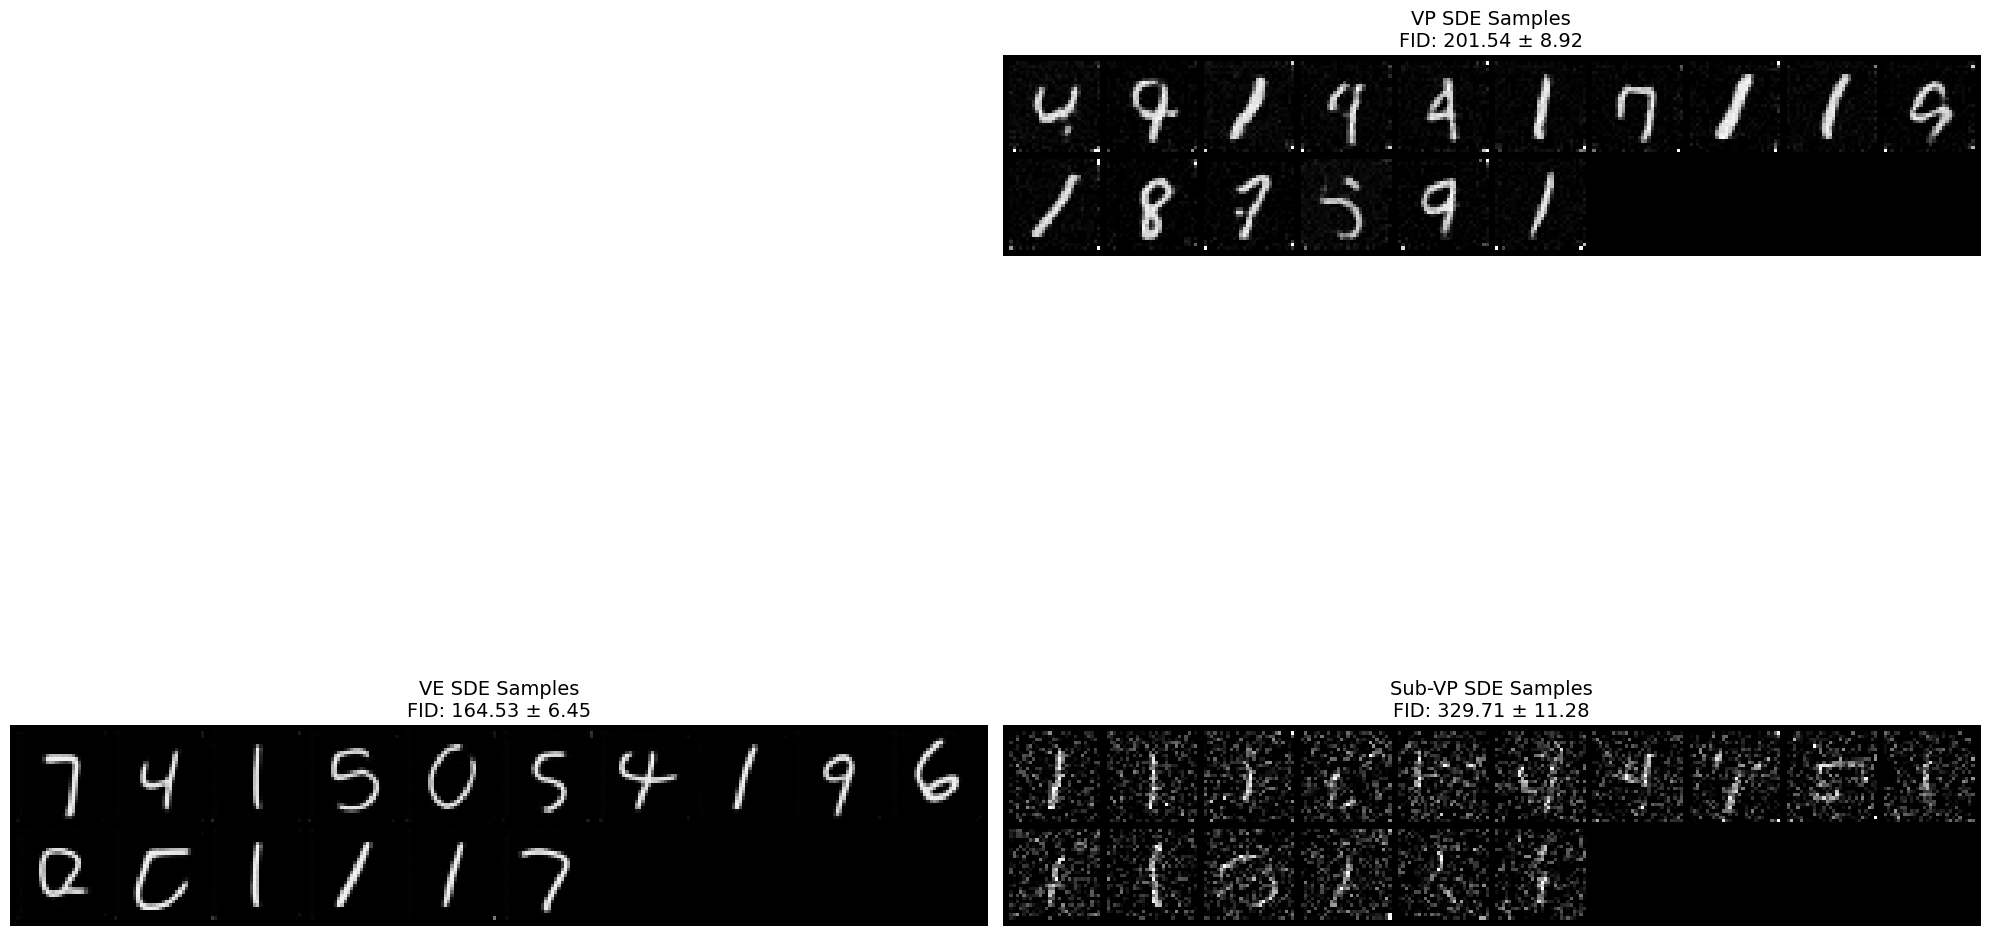

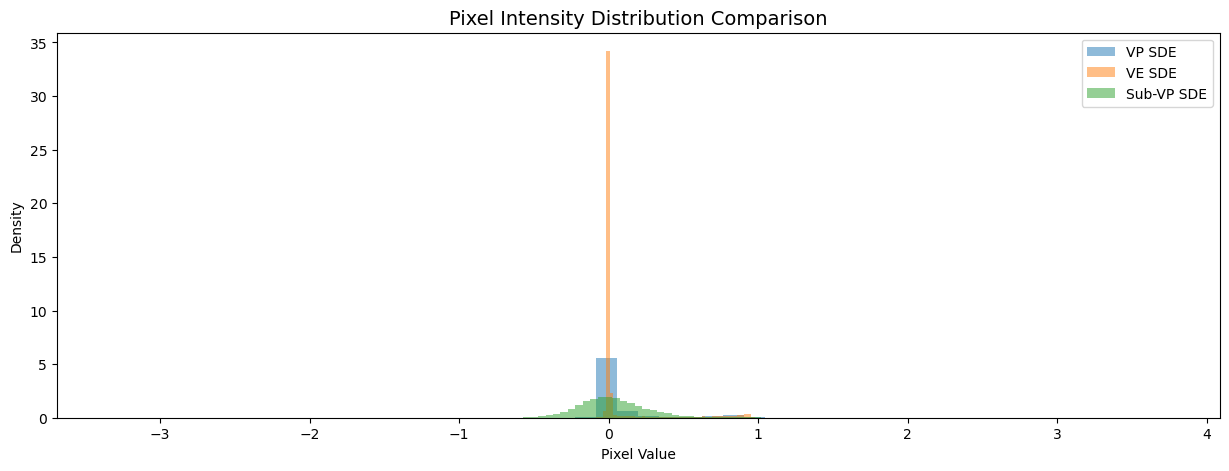

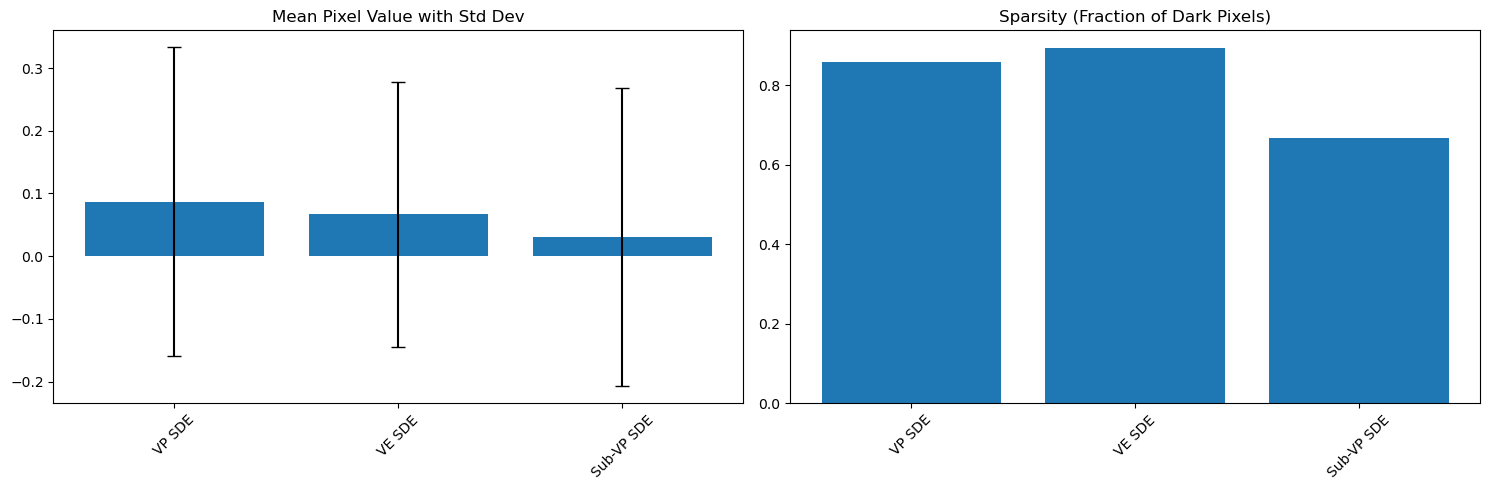

In [93]:

# Or with ODE sampler
results_ode = compare_sde_models_with_viz(
    vp_model=vp_model,
    ve_model=ve_model,
    subvp_model=subvp_model,
    dataloader=dataloader_train,
    device=device,
    sampler_type='ode',
    n_runs=5
)